<a href="https://colab.research.google.com/github/juyee1698/Electra/blob/main/Music_Generation(Bidirectional%20GRU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import glob
import pickle

import tensorflow as tf

from music21 import converter, instrument, stream, note, chord

#Run version 2.1.6
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Bidirectional, Flatten
from keras import utils
from keras.callbacks import ModelCheckpoint
from keras_self_attention import SeqSelfAttention
from keras.layers import GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.layers import BatchNormalization as BatchNorm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras_self_attention

# Data Preparation & Model training

In [ ]:
%pwd

'/content/drive/MyDrive/Classical_tracks'

In [ ]:
#Specify the working directory which contains MIDI tracks

%cd /content/drive/MyDrive/Input_songs/

## Build the notes and chords object for each instrument

In [ ]:
def get_notes():
    notes = []
    durations = []

    sum=0
    count_tracks=0

    for file in glob.glob("*.mid"):
        midi = converter.parse(file)
        count_tracks+=1
        print("Parsing %s" % file)

        notes_to_parse = None
        tmp_notes = []

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi) #Currently we are only working with piano
            for part in s2:
              if isinstance(part.getInstrument(), instrument.Piano) and str(part)!="<music21.stream.Part Piano right>" and str(part)!="<music21.stream.Part Piano left>":
                print("True")
                notes_to_parse = part.recurse()

            #notes_to_parse = s2.parts[0].recurse()
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes
            #print(len(notes_to_parse))

        try:
          for element in notes_to_parse:

              if isinstance(element, note.Note):
                  #print(element, element.offset, element.pitch)
                  notes.append(str(element.pitch) + " " +  str(element.quarterLength))
                  tmp_notes.append(str(element.pitch) + " " +  str(element.quarterLength))
              elif isinstance(element, chord.Chord):
                  #print(element, element.normalOrder, element.quarterLength)
                  notes.append('.'.join(str(n) for n in element.normalOrder) + " " + str(element.quarterLength))
                  tmp_notes.append('.'.join(str(n) for n in element.normalOrder) + " " + str(element.quarterLength))
              elif isinstance(element,  note.Rest):
                  #print(element)
                  notes.append(str(element.name)  + " " + str(element.quarterLength))
                  tmp_notes.append(str(element.name)  + " " + str(element.quarterLength))

          print(len(tmp_notes))
          print(len(set(tmp_notes)))
          sum+=len(set(tmp_notes[0:500]))
        except:
          continue

    #This is used to determine diversity in the track to determine sequence length
    print("Avg no of notes/chords in first 500 sequences is ",(sum/count_tracks))

    return notes

In [ ]:
notes = get_notes()
n_vocab = len(set(notes))

In [ ]:
print(notes)

In [ ]:
print(len(notes))

In [ ]:
n_vocab

## Prepare input and output sequences for the model to learn

In [ ]:
def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 64 #Track will be divided into sequences of 100 notes/chords for the model to learn

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

    print(pitchnames)

    # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))


    print(note_to_int)
    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])
        #print("Network Output ",network_output)

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))


    # normalize input
    network_input = network_input / float(n_vocab)

    #print("Normalized input:",network_input)

    network_output = to_categorical(network_output)
    #print(network_input.shape[1],network_input.shape[2])
    #print(network_output.shape)

    return (network_input, network_output)

In [ ]:
prepare_sequences(notes, n_vocab)

## Build and configure the ML model

In [ ]:
def train_network(notes, n_vocab):
    """ Train a Neural Network to generate music """
    network_input, network_output = prepare_sequences(notes, n_vocab)

    model = create_network(network_input, n_vocab)

    history = train(model, network_input, network_output)

    return history

In [ ]:
def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential(name="GRU-Model") # Model
    # Input Layer
    model.add(Input(shape=(network_input.shape[1],network_input.shape[2]), name='Input-Layer'))
    # Build the Encoder Layer
    model.add(Bidirectional(GRU(units=64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True),
                            name='Hidden-GRU-Encoder-Layer'))
    # Build the Decoder Layer
    model.add(Bidirectional(GRU(units=64, activation='tanh', recurrent_activation='sigmoid'), name='Hidden-GRU-Decoder-Layer'))
    #model.add(TimeDistributed(Dense(units=n_vocab, activation='softmax'), name='Output-Layer')) # Output Layer, Linear(x) = x
    model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    model.add(Dense(n_vocab, activation='softmax'))
    #model.add(Activation('softmax'))

    # Compile the model
    model.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
                  loss='categorical_crossentropy', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
                )

    print(model.summary())

    return model

In [ ]:
# def create_network(network_input, n_vocab):
#     """ create the structure of the neural network """
#     model = Sequential()
#     model.add(Bidirectional(LSTM(512,
#         input_shape=(network_input.shape[1], network_input.shape[2]), #n_time_steps, n_features?
#         return_sequences=True)))
#     model.add(SeqSelfAttention(attention_activation='sigmoid'))
#     model.add(BatchNorm())
#     model.add(Dropout(0.5))

#     # model.add(Bidirectional(LSTM(512,
#     #     return_sequences=True, recurrent_dropout=0.2)))
#     # #model.add(LSTM(512,return_sequences=True))
#     # model.add(BatchNorm())
#     # model.add(Dropout(0.3))

#     #model.add(Flatten()) #Supposedly needed to fix stuff before dense layer
#     model.add(GlobalMaxPooling1D())
#     model.add(Dense(n_vocab))
#     model.add(Activation('softmax'))
#     learning_rate = 0.005
#     optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#     model.compile(loss='categorical_crossentropy', optimizer=optimizer)
#     #model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(
#     #     from_logits=True), optimizer=optimizer)


#     #model.summary()

#     return model

def train(model, network_input, network_output):
    """ train the neural network """
    loss = list()
    filepath = os.path.abspath("/content/weights-2GRULayer-final.hdf5")
    checkpoint = ModelCheckpoint(
        filepath,
        period=10, #Every 10 epochs
        monitor='loss',
        verbose=1,
        patience=5,
        save_weights_only=True,
        restore_best_weights=True,
        mode='min'
    )
    callbacks_list = [checkpoint]

    history = model.fit(network_input, network_output, epochs=100, batch_size=64, callbacks=callbacks_list)
    return history

## Train the Model

In [ ]:
network_input, network_output = prepare_sequences(notes, n_vocab)

model = create_network_add_weights(network_input, n_vocab)
train(model, network_input, network_output)

In [ ]:
#train
model_history = train_network(notes, n_vocab)

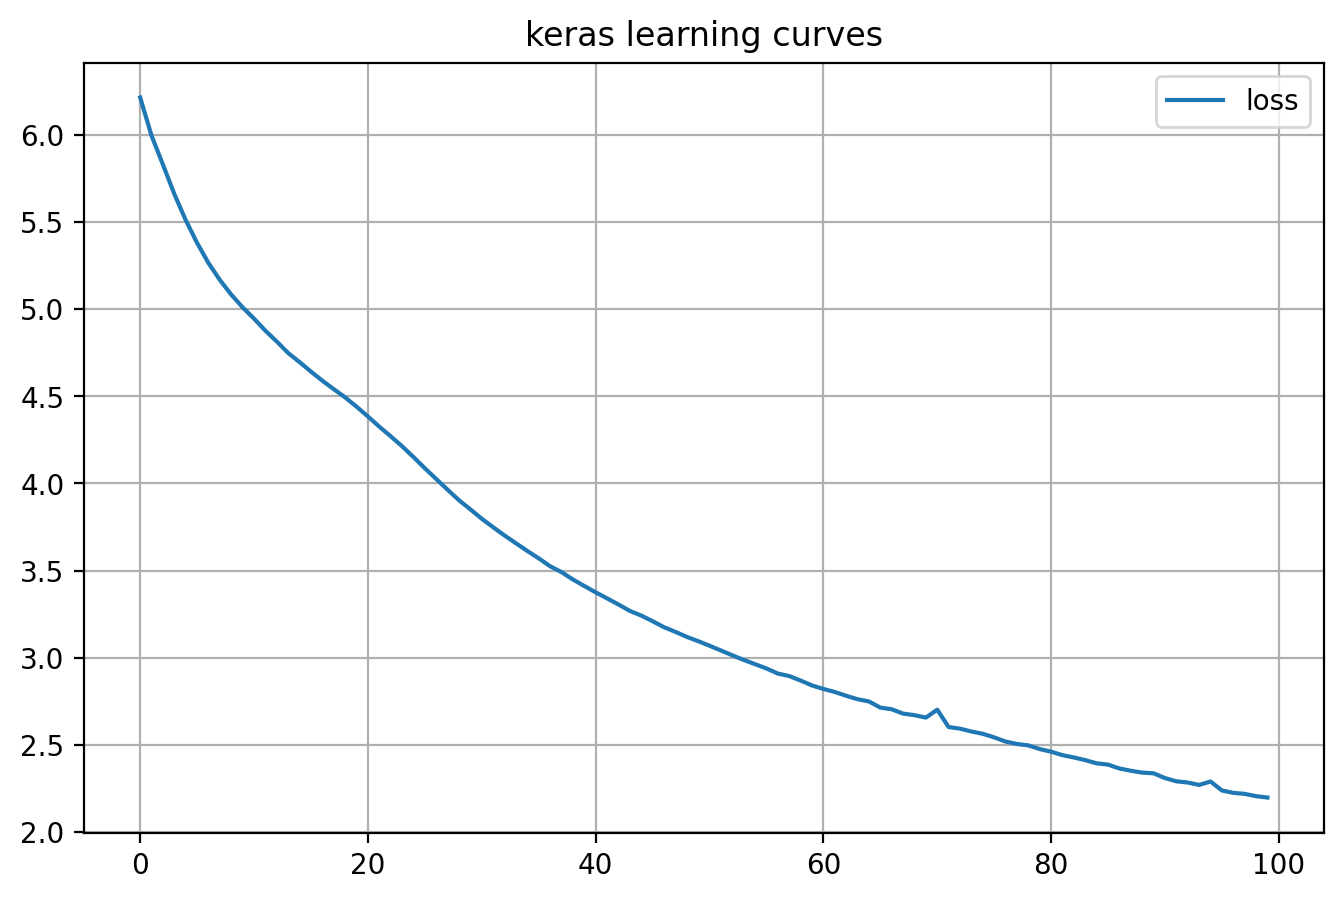

In [ ]:
import pandas as pd
pd.DataFrame(model_history.history).plot(figsize=(8, 5))
plt.grid(True)

plt.title("keras learning curves")
plt.show()

# Generate output sequence

In [ ]:
def generate():
    """ Generate a piano midi file """
    #load the notes used to train the model
    # with open('data/notes', 'rb') as filepath:
    #     notes = pickle.load(filepath)

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
    n_vocab = len(set(notes))

    network_input, normalized_input = prepare_sequences_output(notes, pitchnames, n_vocab)
    model = create_network_add_weights(normalized_input, n_vocab)
    prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)
    create_midi(prediction_output)

In [ ]:
def prepare_sequences_output(notes, pitchnames, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    # map between notes and integers and back
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 64
    network_input = []
    output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    normalized_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    normalized_input = normalized_input / float(n_vocab)

    return (network_input, normalized_input)

In [ ]:
def create_network_add_weights(network_input, n_vocab):
    """ create the structure of the neural network """

    #Build the same architecture as previously designed to load the weights
    model = Sequential()

    # Input Layer
    model.add(Input(shape=(network_input.shape[1],network_input.shape[2]), name='Input-Layer'))
    # Build the Encoder Layer
    model.add(Bidirectional(GRU(units=64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True),
                            name='Hidden-GRU-Encoder-Layer'))
    # Build the Decoder Layer
    model.add(Bidirectional(GRU(units=64, activation='tanh', recurrent_activation='sigmoid'), name='Hidden-GRU-Decoder-Layer'))
    model.add(BatchNormalization())
    model.add(Dense(n_vocab, activation='softmax'))

    # model.add(Bidirectional(LSTM(512,return_sequences=True),input_shape=(network_input.shape[1], network_input.shape[2]))) #n_time_steps, n_features? Needed input_shape in first layer, which is Bid not LSTM
    # model.add(SeqSelfAttention(attention_activation='sigmoid'))
    # model.add(BatchNorm())
    # model.add(Dropout(0.3))

    # #model.add(LSTM(512,return_sequences=True))
    # #model.add(Dropout(0.3))

    # #model.add(Flatten()) #Supposedly needed to fix stuff before dense layer
    # model.add(GlobalMaxPooling1D())
    # model.add(Dense(n_vocab))
    # model.add(Activation('softmax'))
    # model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    # Load the weights to each node
    model.load_weights('/content/weights-2GRULayer-final.hdf5')

    return model


Model uses its weights to predict the next note in the sequence based on the previous sequences

In [ ]:
def generate_notes(model, network_input, pitchnames, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    start = np.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 250 notes
    for note_index in range(250):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = np.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    print(prediction_output)

    return prediction_output

# Create MIDI file

In [ ]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []
    output_notes.append(instrument.Piano())
    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        pattern = pattern.split()
        temp = pattern[0]
        duration = pattern[1]
        pattern = temp
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a rest
        elif('rest' in pattern):
            new_rest = note.Rest()
            new_rest.offset = offset
            new_rest.storedInstrument = instrument.Piano() #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='/content/piano_comp_24102023.mid')

#From: https://stackoverflow.com/questions/1806278/convert-fraction-to-float
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

In [ ]:
generate()

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)